# Canal plan 2D

In [69]:
from trustutils import run 
from trustutils import visit
from trustutils.jupyter import plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import copy
import os, sys
from string import Template
import time
from IPython.display import display

run.introduction("C. Reiss","25/05/2022")
run.description(r'On envoie un liquide dans un canal plan 2D qui a toujours les memes dimensions () pour tester les lois de paroi adaptatives et leur sensibilite au maillage pour differentes discretisations de tau.')

run.TRUST_parameters()

## Introduction 
 Validation made by : C. Reiss



 Report created : 25/05/2022



 Report generated 20/03/2023

### Description 
On envoie un liquide dans un canal plan 2D qui a toujours les memes dimensions () pour tester les lois de paroi adaptatives et leur sensibilite au maillage pour differentes discretisations de tau.

### TRUST parameters 
 * Version TRUST: 1.9.2_beta
 * Binary used: /volatile/catB/cr268029/triocfd/Multiphase/CMFD/CMFD_opt (built in directory /volatile/catB/cr268029/triocfd/Multiphase/CMFD/share/Validation/Rapports_automatiques/canal_plan/build)

In [70]:
force_recalculation = True # if False, existing results will be used if the build directory exists, e.g. the trust-nk calculation will be skipped to quickly show results
number_of_partitions = 4
build_dir = run.BUILD_DIRECTORY

configs = ["PolyMAC_tau_fixe_k_simple","PolyMAC_omega_dix_k_simple", "PolyMAC_omega_demi_k_complique"]
equation = ["echelle_temporelle_turbulente"]+["taux_dissipation_turbulent"]*2
diffusion = [ "k_tau"]+["k_omega"]*2
diss =         ["tau"]+['omega']*2
diss_ext = ["tau_ext"]+["omega_ext"]*2
diss_conv= [" tau 1.e-5 "]+[" omega 1. "]*2
IC_diss =      ["2"]+[str(1./2)]*2
CL_diss = ["scalaire_impose_paroi champ_front_uniforme 1 0 ", "Cond_lim_omega_dix { } ", "Cond_lim_omega_demi { }  "]
CL_k = ["Cond_lim_k_simple_flux_nul ", "Cond_lim_k_simple_flux_nul ", "Cond_lim_k_complique_transition_flux_nul_demi  "]
schema = ["PolyMAC_P0"]
diffusion_sup = [" , Diffusion_supplementaire_echelle_temp_turb "]+[" "] *2

n_calc   = 2

title_raf  = [ 1 ,  2  ,  4  ,  8    ,  20  ,  40   ,  80    ,  120    ,  200 ]
y_0        = [.1 , .05 , .025, .0125 , .005 , .0025 , .00125 , .000833 , .0005]
y_1        = [.2 , .1  , .05 , .05   , .05  , .05   , .05    , .05     , .05  ]
ly_2       = [.2 , .1  , .15 , .15   , .15  , .15   , .15    , .15     , .15  ]
y_2        = np.array(y_1)+np.array(ly_2)
ly_3       = [.6 , .8  , .8  , .8    , .8   , .8    , .8     , .8      , .8   ]
y_3        = np.array(y_2)+np.array(ly_3)
nb_nodes_y1= [ 2 ,  2  ,  2  ,  3    ,  6   ,  11   ,  21    ,  31     ,  51  ]
nb_nodes_y2= [ 2 ,  2  ,  4  ,  7    ,  16  ,  16   ,  21    ,  31     ,  51  ]
nb_nodes_y3= [ 4 ,  9  ,  17 ,  17   ,  21  ,  21   ,  21    ,  31     ,  51  ]
lx         = 100
nb_nodes_x = [ 21,  41 ,  61 ,  61   ,  81  ,  91   ,  121   ,  201    , 301  ]
facsec     = [ 1 ,  1  ,  1  ,  1    ,  1   ,  1    ,  1     ,  1      ,  1   ]
u_0        = 1
rho        = 1e3
mu         = 2e-2
tmax       = 200
nb_pas_dt_max = "1000000"

def GenerateInputFile(name,substitutions_dict):
    with open(f"{build_dir}/jdd.data", "r") as file: 
        filedata = Template(file.read())
    result = filedata.substitute(substitutions_dict)
    with open(f"{build_dir}/{name}.data", "w") as file:
        file.write(result)


if force_recalculation or not os.path.exists(build_dir):
    print('Recalculation running..')
    run.reset()
    # Trigger the deletion of build directory and copy of all files inside the src directory into a new build directory:
    run.defaultSuite_ = run.TRUSTSuite(runPrepare=False)

    for y in range(n_calc) :
        print(f"Adding the launch files for a refinement of {title_raf[y]}")
        os.system(f'mkdir {build_dir}/{title_raf[y]}') 
        for c in range(len(configs)) :
            name = configs[c] + "_raf_" + str(title_raf[y])
            substitutions_dict = {"facsec" : str(facsec[y]),
                                "diffusion_sup" : diffusion_sup[c],
                                "diffusion" : diffusion[c] ,
                                "diss": diss[c],
                                "diss_ext": diss_ext[c],
                                "diss_conv" : diss_conv[c],                                  
                                "IC_diss" : IC_diss[c] ,
                                "CL_diss" : CL_diss[c] ,
                                "CL_k" : CL_k[c] ,
                                "equation" : equation[c],
                                "schema" : schema[0],
                                "nb_pas_dt_max" : nb_pas_dt_max,
                                "y_1" : str(y_1[y]),
                                "ly_2": str(ly_2[y]),
                                "y_2" : str(y_2[y]),
                                "ly_3": str(ly_3[y]),
                                "y_3" : str(y_3[y]),
                                "ny_1": str(nb_nodes_y1[y]),
                                "ny_2": str(nb_nodes_y2[y]),
                                "ny_3": str(nb_nodes_y3[y]),
                                "lx"  : str(lx) ,
                                "nx"  : str(nb_nodes_x[y]) ,
                                "tmax": str(tmax),
                                "rho" : str(rho),
                                "mu"  : str(mu),
                                "u_0" : str(u_0)
                                 }
            GenerateInputFile(name,substitutions_dict)
            if number_of_partitions == 1:
                run.addCase(".", f"{name}.data")
            else:
                os.system(f'mv {build_dir}/{name}.data {build_dir}/{title_raf[y]} ; cd {build_dir}/{title_raf[y]};  make_PAR.data {name} {number_of_partitions}; cd ../..')
                run.addCase(f"./{title_raf[y]}", f"PAR_{name}.data",nbProcs=number_of_partitions)
    run.runCases()
    display(run.tablePerf())

else:
    print('No recalculation, reusing old results!')

No recalculation, reusing old results!


## A remplir

In [71]:
nu = mu/rho
B_w = 0.075
B_k = 0.09
von_karman_ = 0.41
limiteur_y_p = 0.01
u_tau_Blasius = 0.0432

def u_plus_de_y_plus( y_p) :
    reichardt = np.log(1+0.4*y_p)/von_karman_
    reichardt += 7.8
    reichardt += -7.8*np.exp(-y_p/11)
    reichardt += -7.8*y_p/11*np.exp(-y_p/3)

    log_law = np.log(y_p)/von_karman_ + 5.1

    blending = np.tanh( y_p/27*y_p/27*y_p/27*y_p/27)

    return (1-blending)*reichardt + blending*log_law

def tau_plus_de_y_plus(y_p) :
    return 1/omega_plus_de_y_plus(y_p)

def omega_plus_de_y_plus(y_p) :
    arg = y_p/10
    phi = np.tanh(arg**4)
    w_vis_p = 6/(B_w*y_p**2)
    w_log_p = 1/(B_k**0.5*von_karman_*y_p)
    w_1_p = w_vis_p+w_log_p
    w_2_p = (w_vis_p**1.2+w_log_p**1.2)**(1/1.2)
    return phi * w_1_p + (1-phi)*w_2_p

def k_plus_de_y_plus(y_p) :
    f1 = (y_p-1) **3/30
    f2 = 1/np.sqrt(0.09)-.08*abs(4.6 - np.log(y_p))**3
    b1 = np.tanh( (y_p/4)**10)
    b2 = np.tanh( (y_p/2500)**1.4)
    f3 = 1/np.sqrt(0.09)*.25
    return np.maximum((1-b1)*f1 + b1*f2, 0)*(1-b2)+b2*f3



In [72]:
dt_ev = [ [ -1 for y in range(n_calc) ] for c in range(len(configs)) ]
tab_name = copy.deepcopy(dt_ev)
ke  = copy.deepcopy(dt_ev)
res_diss = copy.deepcopy(ke)
vit = copy.deepcopy(ke)
yp_tr = copy.deepcopy(ke)
res = [vit, ke, res_diss, yp_tr]

name_phys = ["vit", "k", "diss"]
mark_WL  = [ "--", "-" ] 
color_raf = ["red", "hotpink", "magenta", "darkviolet", "blue", 'deepskyblue', 'cyan', "lime", "green", "olive", "gold", 'orange', "peru"]

for c in range(len(dt_ev)) :
    for y in range(len(dt_ev[c])) : 
        name = configs[c] + "_raf_" + str(title_raf[y])
#        print("loading " + name + " results...")
        tab_name[c][y] = name
        dt_ev[c][y] = pd.read_csv(f"{build_dir}/{title_raf[y]}/PAR_{name}.dt_ev", "\t")
        dt_ev[c][y] = dt_ev[c][y].iloc[:,:10]
        dt_ev[c][y].columns = ['time', 'dt', 'facsec', 'residu', 'dt_stab', 'vit', 'alpha', 'T', 'diss', 'k']

        res[0][c][y] = np.array(plot.loadText(f"{title_raf[y]}/PAR_{name}_VIT.son")[1::2,1])
        res[1][c][y] = np.array(plot.loadText(f"{title_raf[y]}/PAR_{name}_K.son")[1::,1])
        res[2][c][y] = np.array(plot.loadText(f"{title_raf[y]}/PAR_{name}_DISS.son")[1::,1])
        res[3][c][y] = plot.loadText(f"{build_dir}/{title_raf[y]}/PAR_{name}_Y_PLUS.son")[1,1]

#        print(name + " results successfully loaded !")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

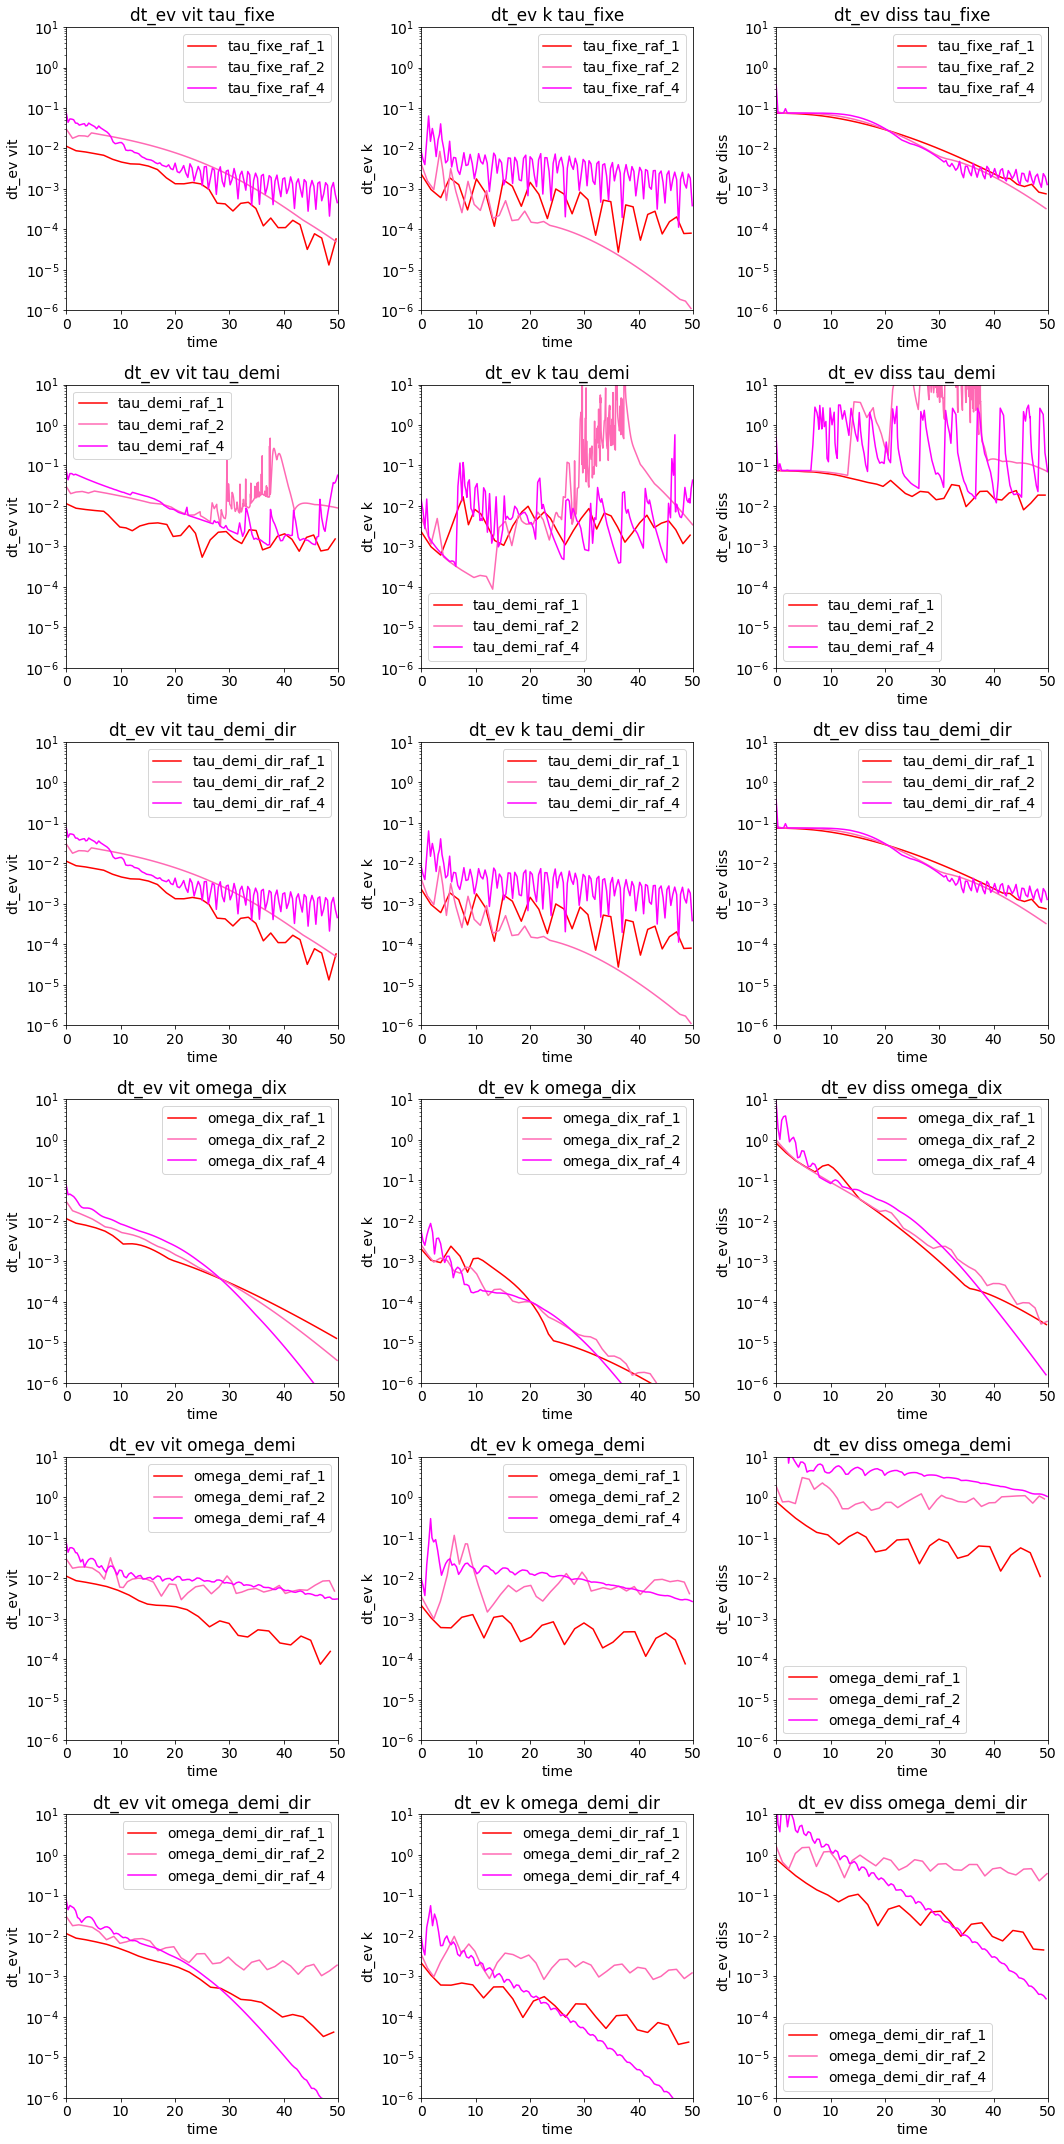

In [ ]:
matplotlib.rcParams.update({'font.size': 14})

fig = plt.figure(figsize = (15,5*len(configs)))
axs = fig.subplots(len(configs), 3)

for p in range(len(name_phys)) :
    for c in range(len(dt_ev)) :
        for y in range(len(dt_ev[c])) : 
            axs[c,p].plot(dt_ev[c][y]["time"][::], dt_ev[c][y][name_phys[p]][::], label = f"raf {title_raf[y]}", color = color_raf[y])

        axs[c,p].set_xlim(0,200)
        axs[c,p].set_ylim(1e-6, 1e1)
        axs[c,p].set_yscale("log")
        axs[c,p].set_title(name_phys[p] + " " + configs[c])
        axs[c,p].set_xlabel('time')
        axs[c,p].set_ylabel("dt_ev " + name_phys[p])
        axs[c,p].legend()

plt.tight_layout()
plt.savefig("convergence.pdf")

TypeError: 'int' object is not subscriptable

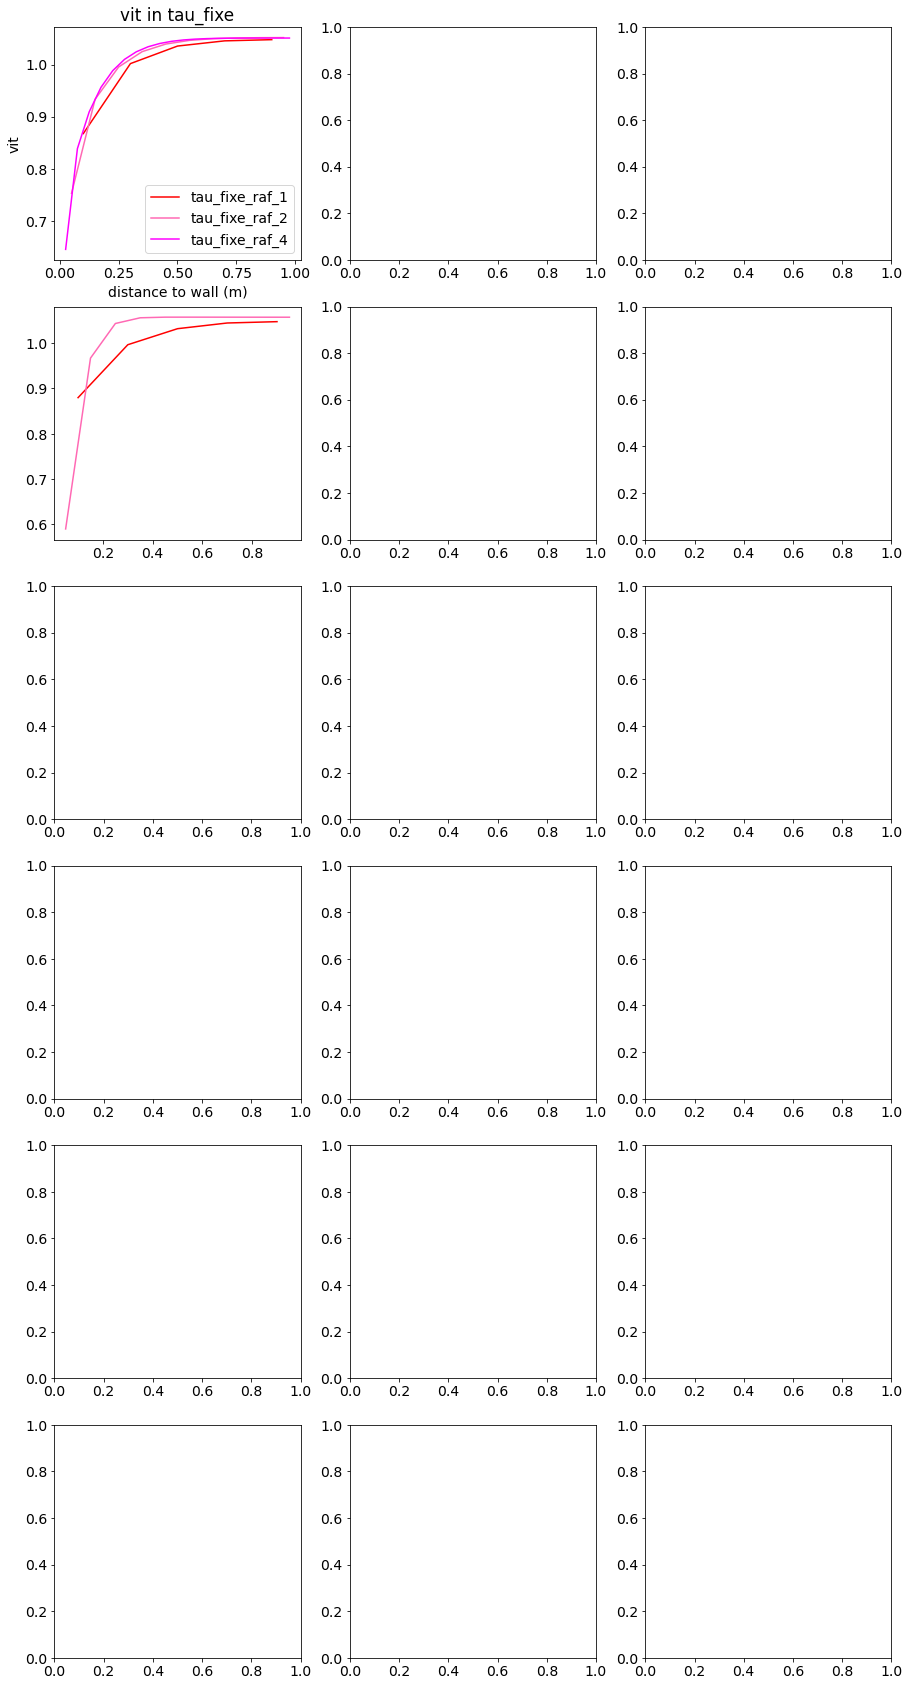

In [73]:
# plot raw results

y_absc = np.linspace(0.00025, 0.99975 ,1000)
y_min = [0 for i in range(len(y_0))]
y_pas = [0 for i in range(len(y_0))]
for y in range(len(y_0)) :
    y_min[y] = int( (y_0[y]+1e-8) * 1000)
    y_pas[y] = int( (y_1[y]+1e-8) * 1000 / (nb_nodes_y1[y]-1))


fig = plt.figure(figsize = (15,5*len(configs)))
axs = fig.subplots(len(configs), 3)

scale = ["log", "linear"]

for p in range(len(name_phys)) :
    for c in range(len(dt_ev)) :
        for y in range(len(dt_ev[c])) : 
            axs[c,p].plot(y_absc[y_min[y]::y_pas[y]], res[p][c][y][y_min[y]::y_pas[y]], label =  f"raf {title_raf[y]}", color = color_raf[y])
        axs[c,p].set_title(f"{name_phys[p]} in {configs[c]}")
        axs[c,p].set_xlabel("distance to wall (m)")
        axs[c,p].set_ylabel(name_phys[p])
        axs[c,p].legend()

plt.tight_layout()
plt.savefig("raw_results.pdf")


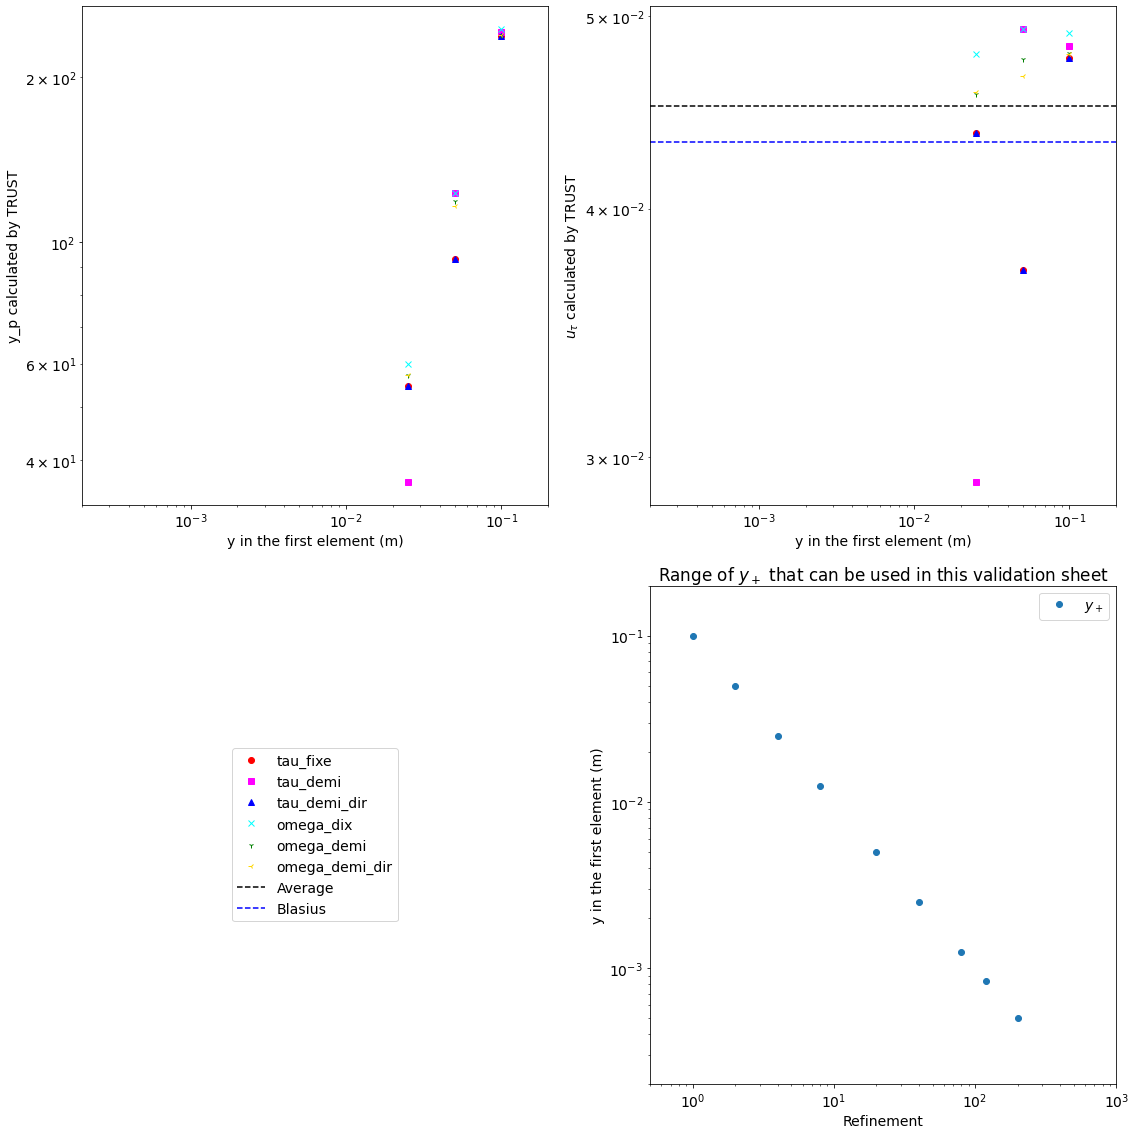

<Figure size 432x288 with 0 Axes>

In [ ]:
# extract u_tau from calculation

mark_dot_k = ["o", "s", "^", "x", "1", "3"]

plt.figure(figsize = (16,16))

plt.subplot(221)

for c in range(len(dt_ev)) : #diss
    for y in range(len(dt_ev[c])) : # raf
        if y == 0 :
            plt.plot(y_0[y], res[3][c][y], mark_dot_k[c], color = color_raf[2*c], label = tab_name[c][y])
        else : 
            plt.plot(y_0[y], res[3][c][y], mark_dot_k[c], color = color_raf[2*c])


plt.xlim(2e-4, 2e-1)
plt.xlabel(r"y in the first element (m)")
plt.ylabel("y_p calculated by TRUST")
plt.yscale("log")
plt.xscale("log")
#plt.legend(prop={'size': 10})

plt.subplot(222)

u_tau_calc = 0
n_calc_u_tau = 0

for c in range(len(dt_ev)) : #diss
    for y in range(len(dt_ev[c])) : # raf
        if y == 0 :
            plt.plot(y_0[y], res[3][c][y]*nu/y_0[y], mark_dot_k[c], label = tab_name[c][0], color = color_raf[2*c])
        else : 
            plt.plot(y_0[y], res[3][c][y]*nu/y_0[y], mark_dot_k[c], color = color_raf[2*c])
        u_tau_calc += res[3][c][y]*nu/y_0[y]
        n_calc_u_tau+=1

u_tau_calc /= n_calc_u_tau

plt.xlim(2e-4, 2e-1)
plt.xlabel(r"y in the first element (m)")
plt.ylabel(r"$u_\tau$ calculated by TRUST")
plt.yscale("log")
plt.xscale("log")
plt.plot([2e-4, 2e-1], [u_tau_calc, u_tau_calc], 'k--', label = "Average")
plt.plot([2e-4, 2e-1], [u_tau_Blasius, u_tau_Blasius], 'b--', label = "Blasius")

#plt.legend(prop={'size': 10})

plt.subplot(223)

for c in range(len(dt_ev)) : #diss
    for y in range(len(dt_ev[c])) : # raf
        if y == 0 :
            plt.plot([0], [0], mark_dot_k[c], label = configs[c], color = color_raf[2*c])

plt.plot([0, .1], [0, .1], 'k--', label = "Average")
plt.plot([0, .1], [0, .1], 'b--', label = "Blasius")

plt.xlim(1,2)
plt.ylim(1,2)
plt.axis('off')
plt.legend(loc='center')
                
# y_0 pour differents raffinements

plt.subplot(224)

y_p_0 = np.array(y_0) * u_tau_Blasius / nu

plt.plot(title_raf, y_0, 'o', label = "$y_+$")
plt.xscale('log')
plt.yscale('log')

#for y in range(len(y_0)):
#    plt.annotate(str(y_p_0[y])[:4],xy=(title_raf[y]*1.2,y_0[y]))

plt.xlim(.5, 1000)
plt.ylim(2e-4, .2)
plt.legend()
plt.title(r"Range of $y_+$ that can be used in this validation sheet")
plt.xlabel("Refinement")
plt.ylabel("y in the first element (m)")
plt.tight_layout()
plt.show()

u_tau_mano = u_tau_calc+0.001
u_tau = u_tau_Blasius+0.0025

plt.tight_layout()

y_p_th = np.array([ 10**(i/300) for i in range(1000)])

y_p = np.array(y_absc) * u_tau/nu
y_p_0 = np.array(y_0) * u_tau/nu
tab_res_p = copy.deepcopy(res)
tab_th = [[u_plus_de_y_plus(y_p), k_plus_de_y_plus(y_p), tau_plus_de_y_plus(y_p)] for i in range(1) ]
tab_th+= [[u_plus_de_y_plus(y_p), k_plus_de_y_plus(y_p), omega_plus_de_y_plus(y_p)] for i in range(2) ]
for c in range(len(dt_ev)) : #tau
    for y in range(len(dt_ev[c])) : # raf
        tab_res_p[0][c][y] /= u_tau
        tab_res_p[1][c][y] /= u_tau**2
        if diss[c]=='tau':
            tab_res_p[2][c][y] *= u_tau**2/nu
        elif diss[c]=='omega':
            tab_res_p[2][c][y] /= u_tau**2/nu


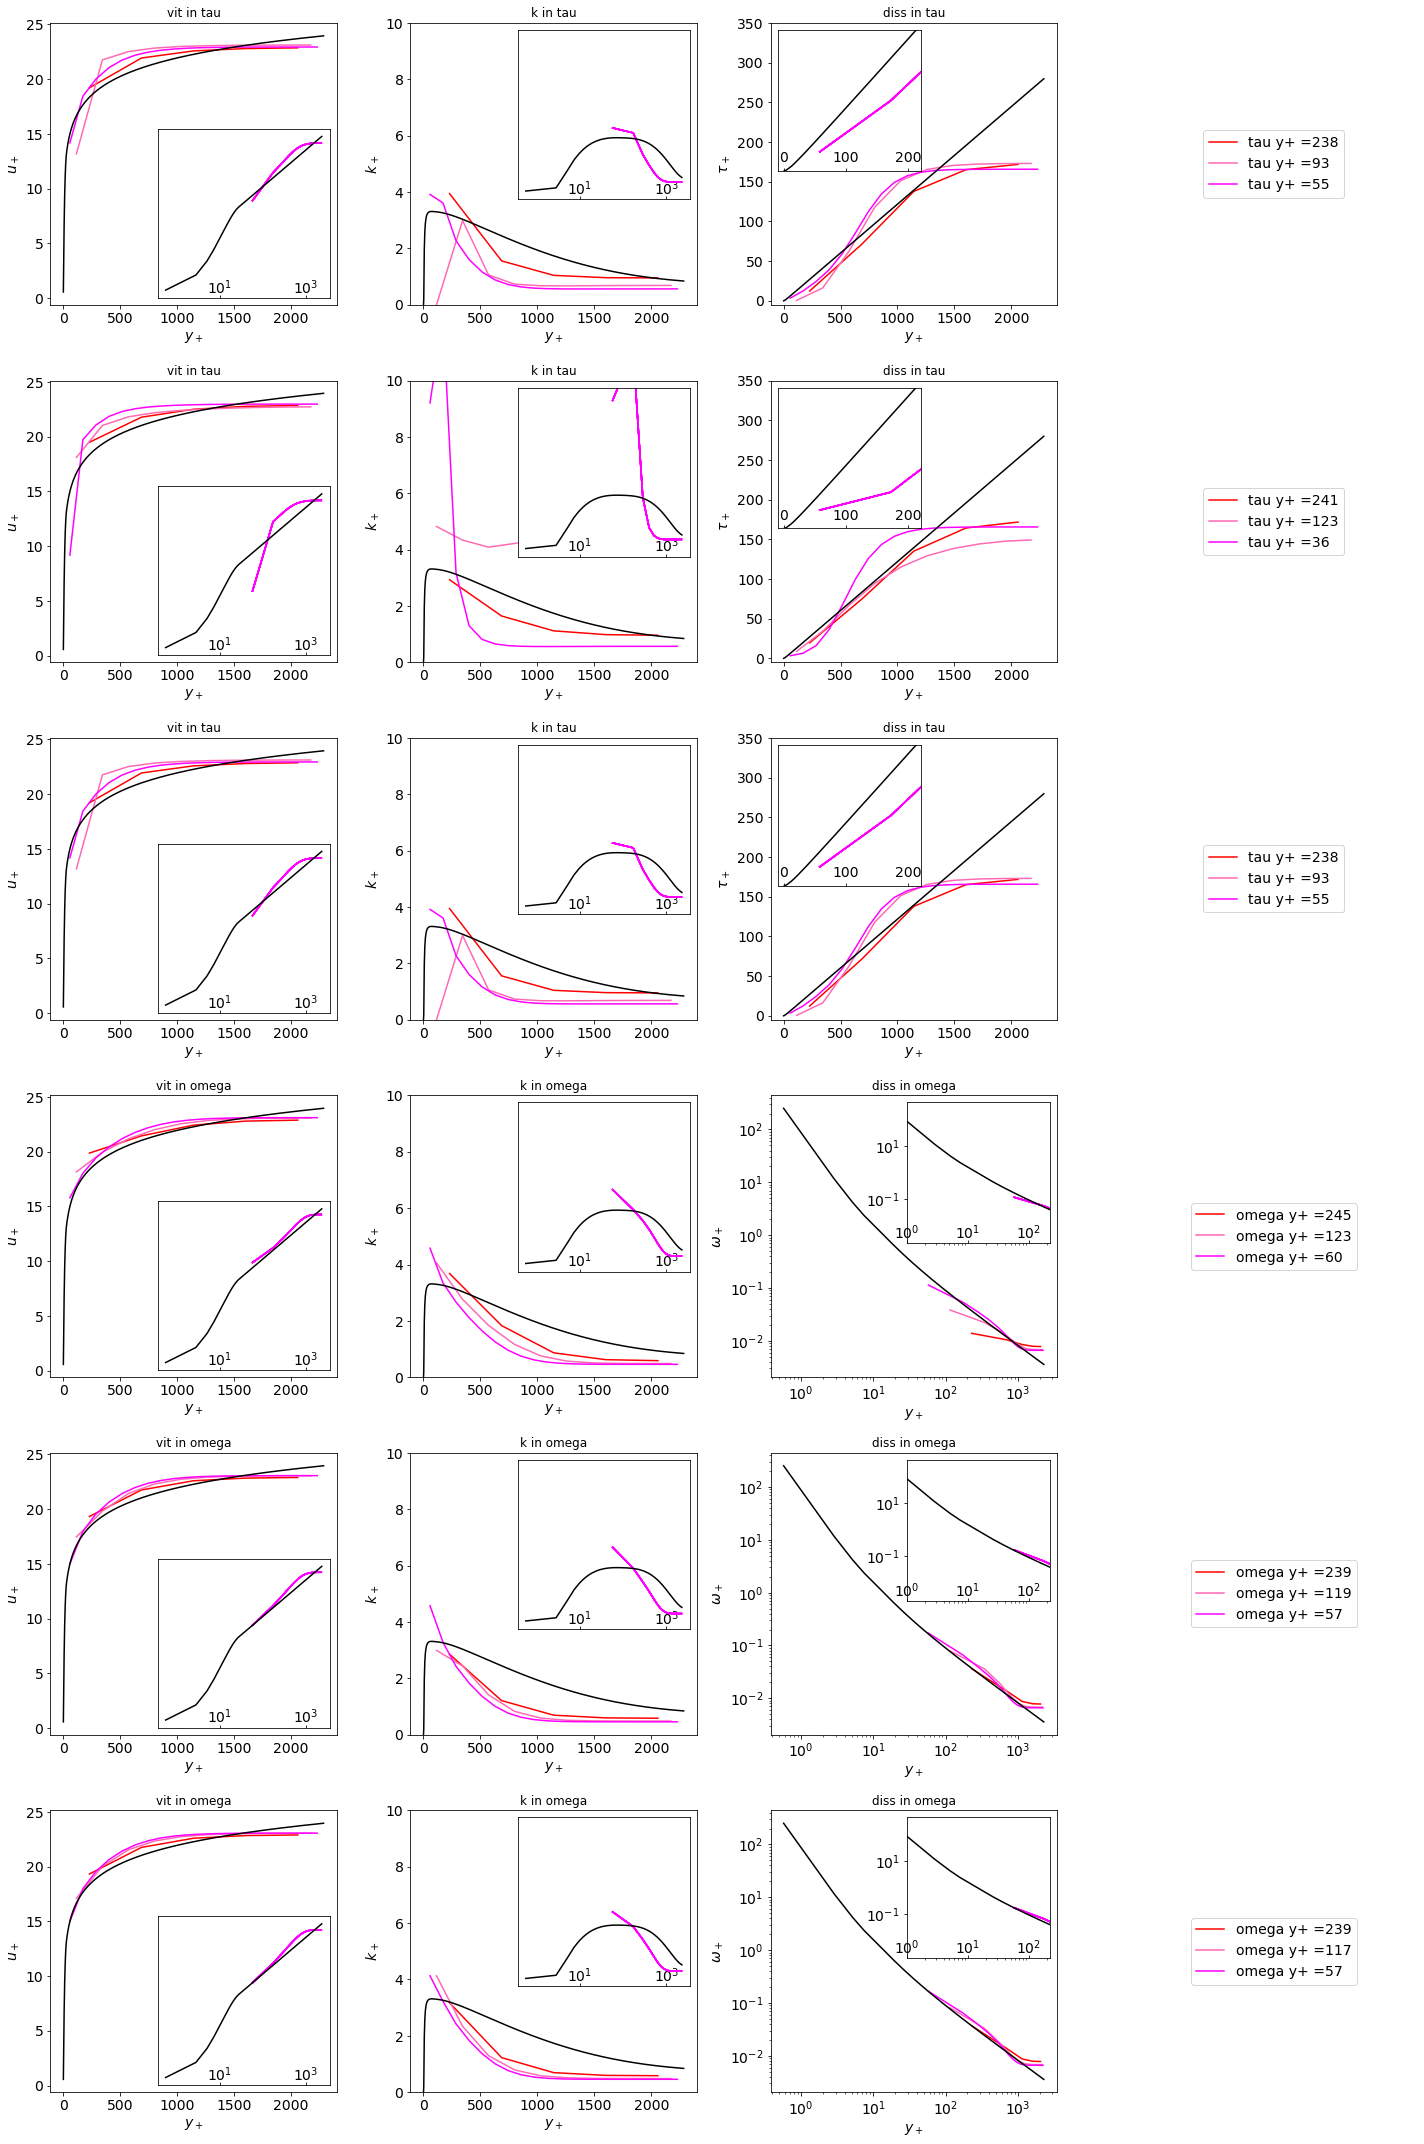

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize = (20,5*len(configs)))
axs = fig.subplots(len(configs), 4)

tab_loc = [[4 , 1 , 2] for i in range(1) ] + [[4 , 1 , 1] for i in range(2) ]
tab_size_inset = ["60%", "60%", "50%"]
y_ax_name = [[r"$u_+$", r"$k_+$", r"$\tau_+$"] for i in range(1)] + [[r"$u_+$", r"$k_+$", r"$\omega_+$"] for i in range(2)]
inset_scale = ["log", "log", "linear"]

for p in range(3) :
    for c in range(len(dt_ev)) : #diss
        for y in range(len(dt_ev[c])) : # raf
            axs[c,p].plot(y_p[y_min[y]::y_pas[y]], tab_res_p[p][c][y][y_min[y]::y_pas[y]], label = tab_name[c][y], color = color_raf[y])
            
        axs[c,p].plot(y_p, tab_th[c][p%3], "k",  label = "theory")
        axs[c,p].set_xscale("linear")
        axs[c,p].set_title(f"{name_phys[p]} in {diss[c]}", fontsize=12)
        axs[c,p].set_xlabel(r"$y_+$")
        axs[c,p].set_ylabel(y_ax_name[c][p])

        if p==1 :
            axs[c,p].set_ylim(0,10)

        if p != 3 :
            inset_ax = inset_axes(axs[c,p], 
                        width=tab_size_inset[p], # width = 30% of parent_bbox
                        height=tab_size_inset[p], # height : 1 inch
                        loc=tab_loc[c][p])

            for j in range(len(dt_ev[c])) : # WL
                for k in range(len(dt_ev[c])) : # raf
                    inset_ax.plot(y_p[y_min[y]::y_pas[y]], tab_res_p[p][c][y][y_min[y]::y_pas[y]], color = color_raf[y])

            inset_ax.plot(y_p, tab_th[c][p%3], "k",  label = "BL theory")
            inset_ax.set_xscale(inset_scale[p])
            inset_ax.set_yticks([])
            inset_ax.tick_params(axis="x",direction="in", pad=-20)
            if p==1 :
                inset_ax.set_ylim(-.5, 10)
                inset_ax.plot()

            if p==2 :
                if diss[c]=='tau':
                    inset_ax.set_xlim(-10,220)
                    inset_ax.set_ylim(0, 25)
                if diss[c]=='omega':
                    inset_ax.set_yscale("log")
                    inset_ax.set_xscale("log")
                    inset_ax.set_xlim(1,220)

        if p==2 :
        #            axs[c,p].legend(prop={'size': 10})
            if diss[c]=='tau':
                axs[c,p].set_ylim(-5, 350)
            if diss[c]=='omega':
                axs[c,p].set_yscale("log")
                axs[c,p].set_xscale("log")

p=3
for c in range(len(dt_ev)) : #diss
    for y in range(len(dt_ev[c])) : # raf
        axs[c,p].plot([0,.1], [0,.1], label = f"{diss[c]} y+ ={int(res[3][c][y]+.49)}", color = color_raf[y])
    axs[c,p].legend(loc='center')

    axs[c,p].set_xlim(1,2)
    axs[c,p].set_ylim(1,2)
    axs[c,p].axis('off')
    
plt.tight_layout()

plt.savefig("tau_omega_adaptatif.pdf")

In [ ]:
# y_0 pour differents raffinements

fig = plt.figure(figsize = (6,4))

y_p_0 = np.array(y_0) * u_tau / nu

plt.plot(title_raf, y_0, 'o', label = "$y_+$")
plt.xscale('log')
plt.yscale('log')

for i in range(len(y_0)):
    plt.annotate(str(y_p_0[i])[:4],xy=(title_raf[i]*1.2,y_0[i]))

plt.xlim(.5, 1000)
plt.ylim(2e-4, .2)
plt.legend()
plt.title(r"Range of $y_+$ that can be used in this validation sheet")
plt.xlabel("Refinement")
plt.ylabel("y in the first element (m)")
plt.tight_layout()
plt.show()

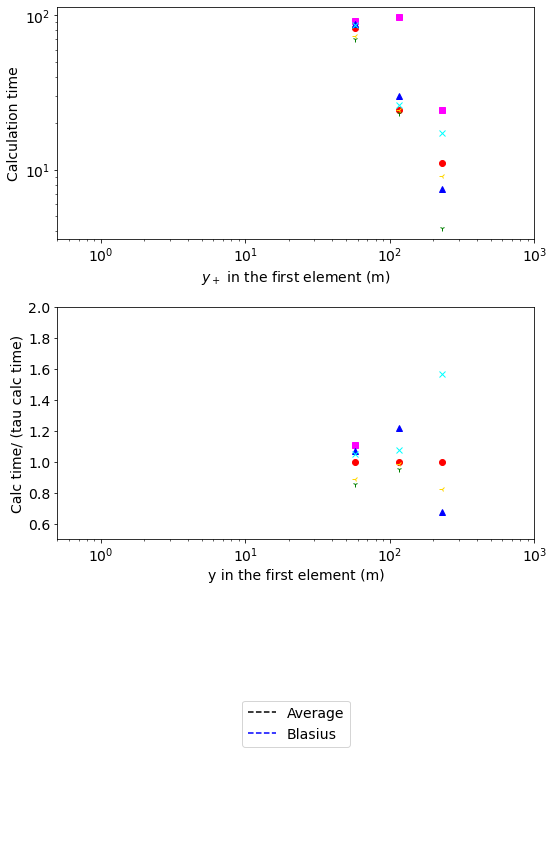

In [ ]:
# temps de calcul pour differentes diffusions
time = [ [ -1 for y in range(n_calc) ] for d in range(len(tab_name))]

plt.figure(figsize = (8,12))

plt.subplot(311)

for c in range(len(dt_ev)) : #diss
    for y in range(len(dt_ev[c])) : # raf
        f = os.open(f"./build/{title_raf[y]}/PAR_{tab_name[c][y]}.perf", os.O_RDONLY)
        time[c][y] = float(os.read(f, 200).split()[3])
        plt.plot(y_p_0[y], time[c][y], mark_dot_k[c], label = tab_name[c][y], color = color_raf[2*c])

plt.xlim(.5, 1000)
plt.xlabel(r"$y_+$ in the first element (m)")
plt.ylabel("Calculation time")
plt.yscale("log")
plt.xscale("log")
#plt.legend(prop={'size': 10})

plt.subplot(312)

for c in range(len(dt_ev)) : #diss
    for y in range(len(dt_ev[c])) : # raf
        if y == 0 :
            plt.plot(y_p_0[y], time[c][y]/time[0][y], mark_dot_k[c], label = diss[c], color = color_raf[2*c])
        else : 
            plt.plot(y_p_0[y], time[c][y]/time[0][y], mark_dot_k[c], color = color_raf[2*c])


plt.xlim(.5, 1000)
plt.xlabel("y in the first element (m)")
plt.ylabel("Calc time/ (tau calc time)")
plt.xscale("log")
plt.ylim(.5, 2)
plt.subplot(313)

for c in range(len(dt_ev)) : #diss
    for y in range(len(dt_ev[c])) : # raf
        if k == 0 :
            plt.plot([0], [0], mark_dot_k[c], color = color_raf[2*c], label = diss[c] )

plt.plot([0, .1], [0, .1], 'k--', label = "Average")
plt.plot([0, .1], [0, .1], 'b--', label = "Blasius")

plt.xlim(1,2)
plt.ylim(1,2)
plt.axis('off')
plt.legend(loc='center')


plt.tight_layout()